# Setup

In [2]:
import sys
sys.path.append('..')

import pandas as pd
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

import model
from utils.data_utils import Season
from utils.model_utils import Feature
from data.load_footystats import GenerateDataFrame
from data.process import DataProcessor, DataSet
from data.load_csv import DataLoader

# Data Load

In [4]:
df_past1 = GenerateDataFrame(season=Season.Past1).load()
df_past2 = GenerateDataFrame(season=Season.Past2).load()
df_past5 = GenerateDataFrame(season=Season.Past5).load()
df_past10 = GenerateDataFrame(season=Season.Past10).load()

In [25]:
data, _, _ = model.pre_process_data(df_past10)
data = data.X

# Implied Probability Computation

In [ ]:
data['B365HProb'] = 1 / data['B365H']
data['B365DProb'] = 1 / data['B365D']
data['B365AProb'] = 1 / data['B365A']

# Adjust the implied probabilities to remove the over-round
ip_sum = data['B365HProb'] + data['B365DProb'] + data['B365AProb']
over_round = ip_sum - 1
adjust = over_round / ip_sum

data['B365HProb'] -= adjust * data['B365HProb']
data['B365DProb'] -= adjust * data['B365DProb']
data['B365AProb'] -= adjust * data['B365AProb']

# Plot Implied Probabilities vs. Actual Probabilities

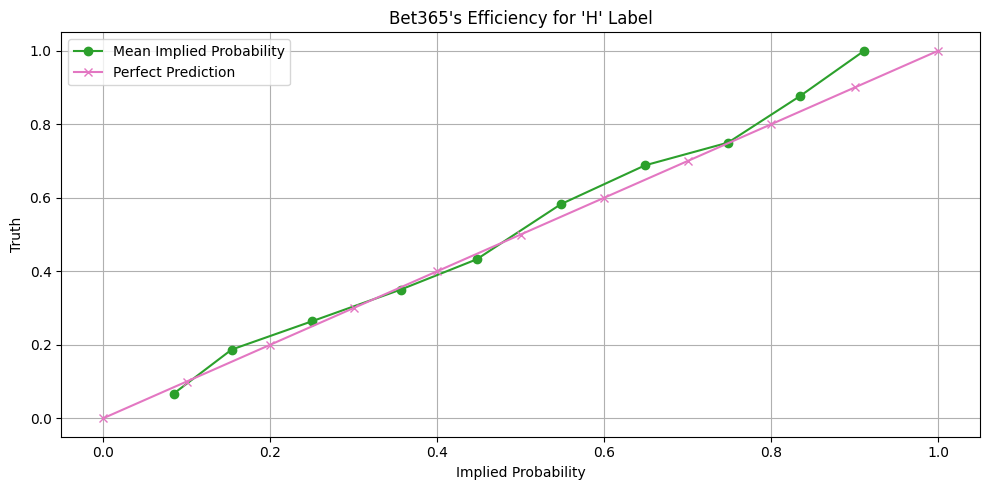

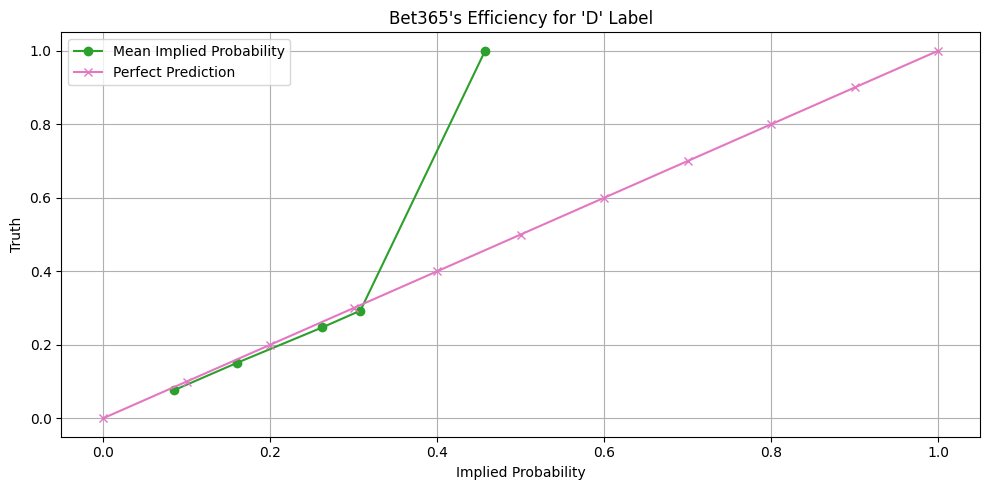

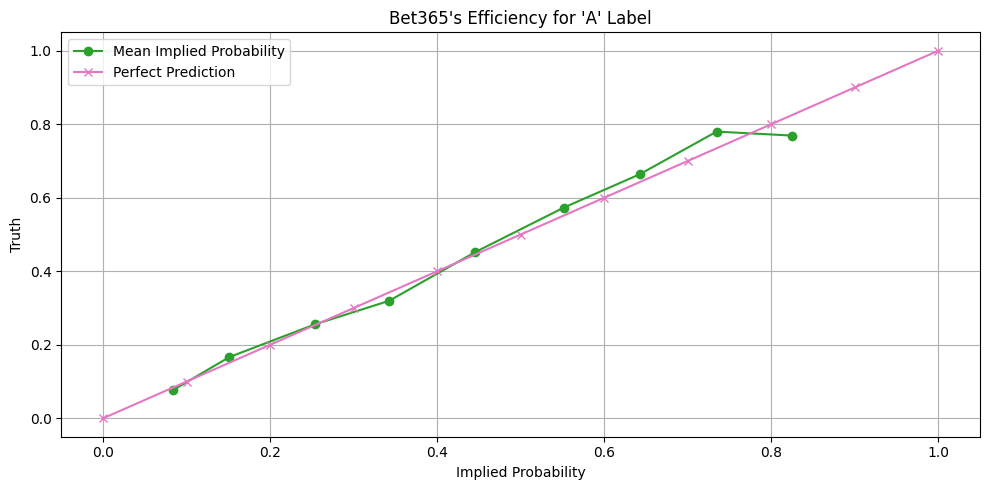

In [65]:

bins = [x / 10 for x in range(11)]
for label in ['H', 'D', 'A']:
    data['bins'] = pd.cut(data[f'B365{label}Prob'], bins=bins)
    
    # Compute the real percentage and implied probablility of each outcome for each bin
    real_prob = data.groupby('bins').apply(lambda x: (x['FTR'] == label).mean())
    implied_prob = data.groupby('bins')[f'B365{label}Prob'].mean()
    
    plt.figure(figsize=(10, 5))
    plt.plot(implied_prob, real_prob, marker='o', color='tab:green')
    plt.plot(bins, bins, color='tab:pink', marker='x')
    plt.title(f"Bet365's Efficiency for '{label}' Label")
    plt.xlabel('Implied Probability')
    plt.ylabel('Truth')

    # add legend
    plt.legend(['Mean Implied Probability', 'Perfect Prediction'])
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'fb_bias_{label}.pdf')

plt.show()

# Plot Receiver Operating Characteristic (ROC) curve and compute Area Under the Curve (AUC)

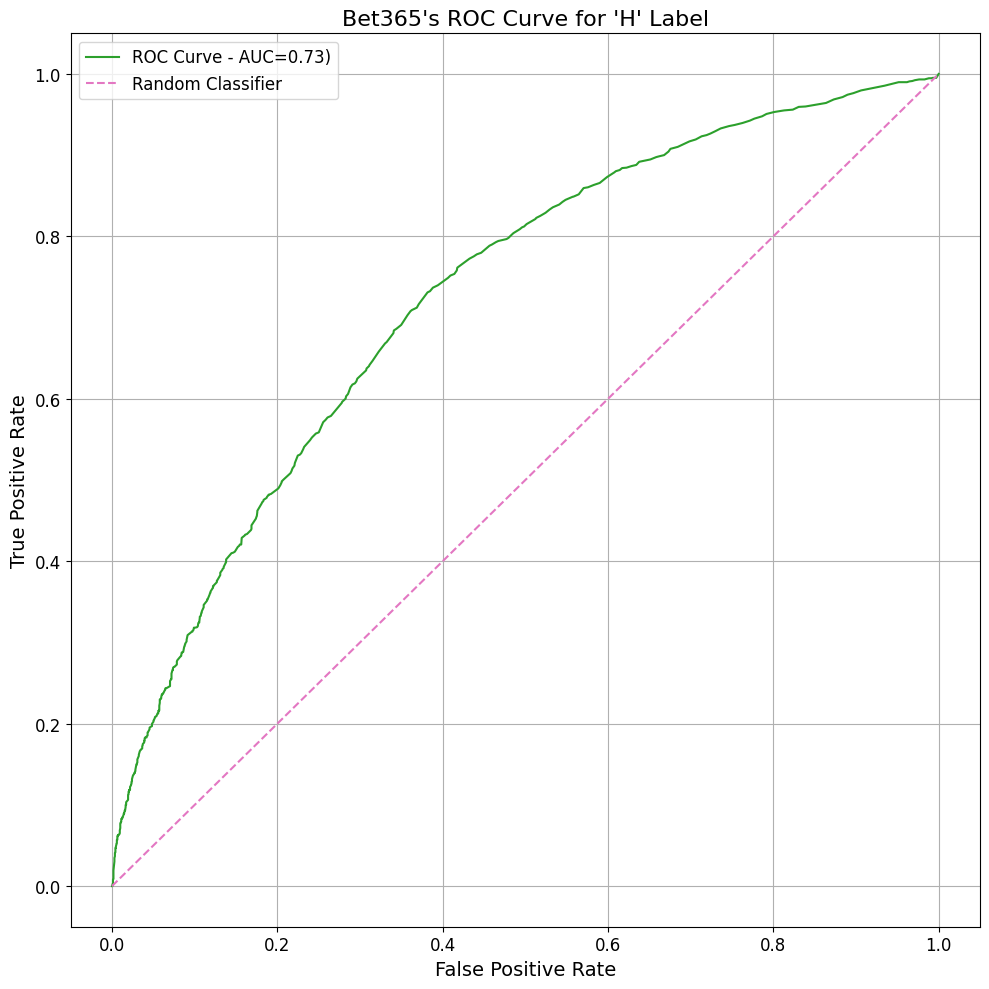

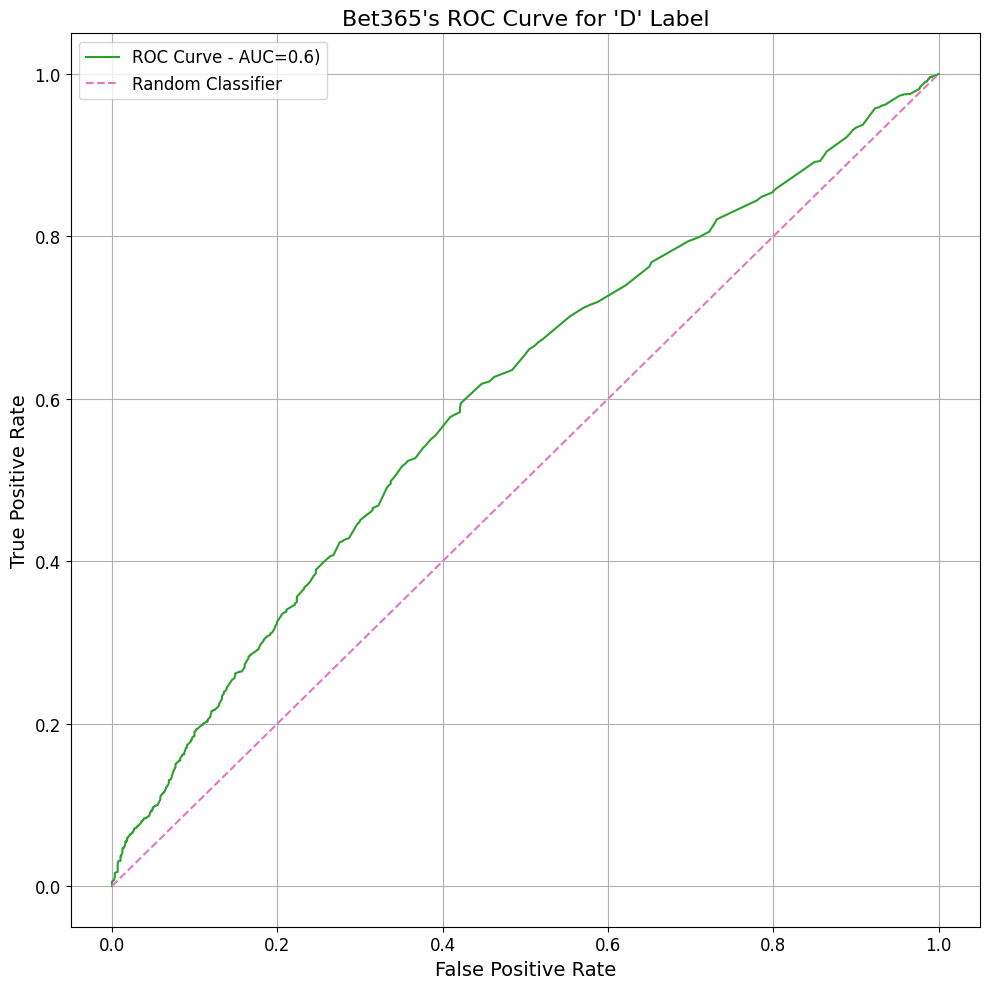

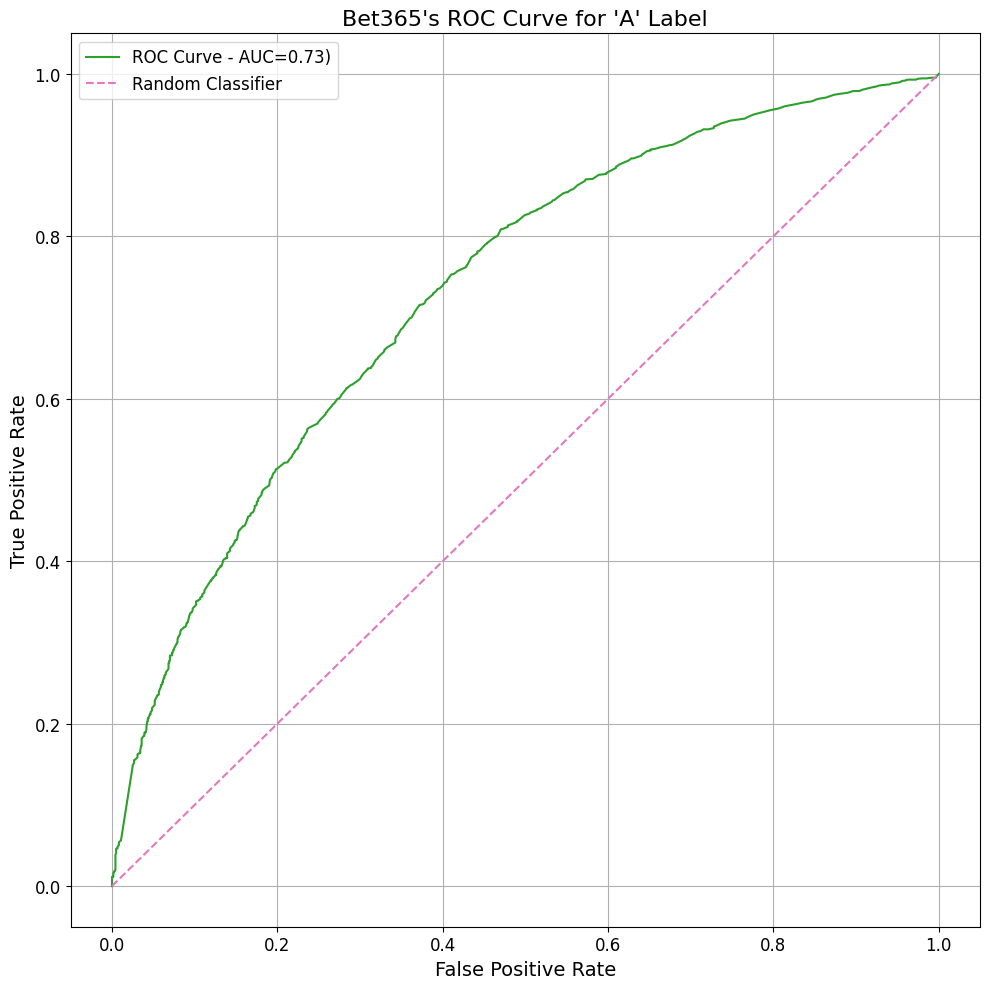

In [78]:
for label in ['H', 'D', 'A']:
    fpr, tpr, _ = roc_curve(data['FTR'] == label, data[f'B365{label}'])
    plt.figure(figsize=(10, 10))
    plt.plot(tpr, fpr, color='tab:green')
    plt.plot([0, 1], [0, 1], color='tab:pink', linestyle='--')
    plt.title(f"Bet365's ROC Curve for '{label}' Label", fontsize=16)
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

    area = 1 - round(roc_auc_score(data['FTR'] == label, data[f'B365{label}']), 2)
    plt.legend([f'ROC Curve - AUC={area})', 'Random Classifier'], fontsize=12)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f'fb_roc_{label}.pdf')

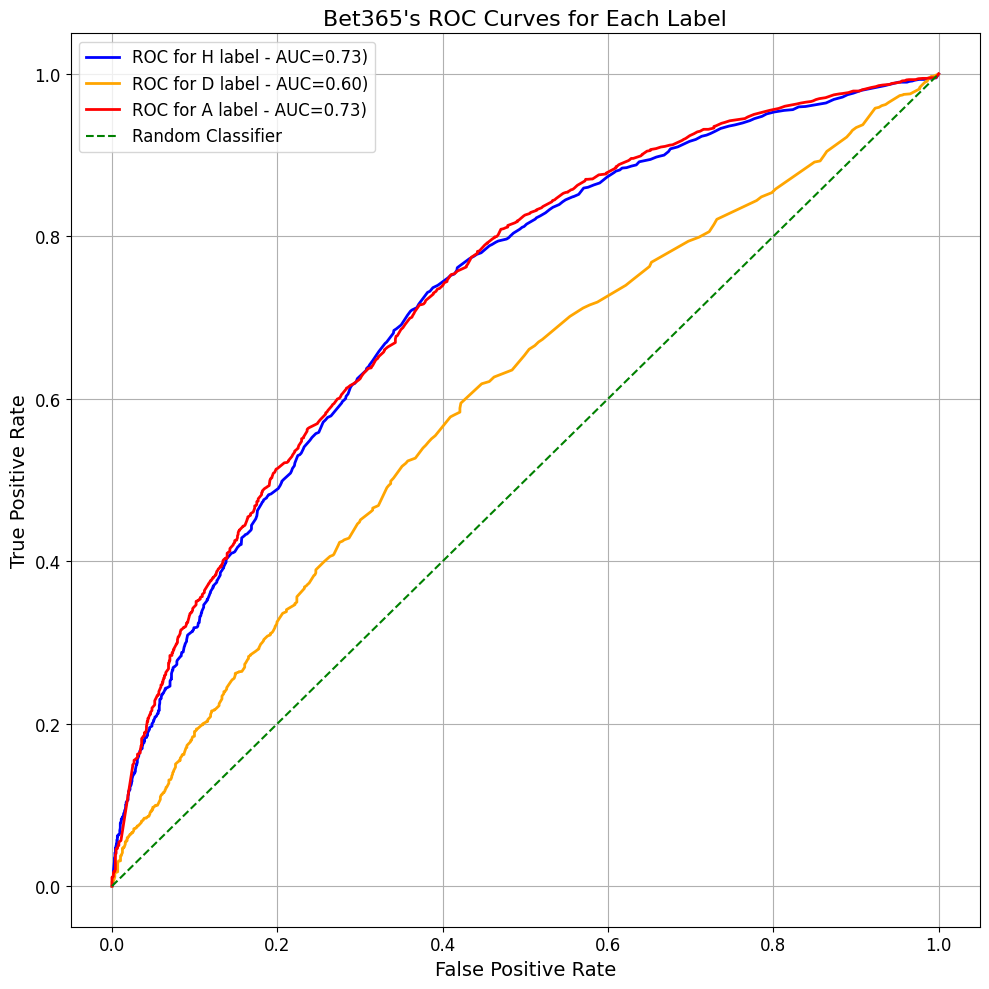

In [90]:
from sklearn.metrics import roc_curve, roc_auc_score

# Plot ROC curves for the bookmakers' odds for each outcome on the same plot
plt.figure(figsize=(10, 10))

colors = ['blue', 'orange', 'red']
labels = ['H', 'D', 'A']

for label, color in zip(labels, colors):
    fpr, tpr, _ = roc_curve(data['FTR'] == label, data[f'B365{label}'])
    roc_auc = 1 - roc_auc_score(data['FTR'] == label, data[f'B365{label}'])
    plt.plot(tpr, fpr, color=color, label=f"ROC for {label} label - AUC={roc_auc:.2f})", linewidth=2)

plt.plot([0, 1], [0, 1], color='green', linestyle='--', label='Random Classifier')
plt.title("Bet365's ROC Curves for Each Label", fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()

plt.savefig('fb_roc_all.pdf')
plt.show()

# Backtesting

In [3]:
df = GenerateDataFrame(season=Season.Past6).load()
df = df[df['Date'] < '2023-08-01']
len(df)


1900

In [28]:
# first 1710 matches
curr_train_test = df.iloc[:1720]
curr_remaining = df.iloc[1720:]

len(curr_train_test), len(curr_remaining)

(1720, 180)

In [31]:
MATCHES_PER_ROUND = 10

PARAMS = {
    Feature.GOAL_STATS.value: False,
    Feature.ODDS.value: True,
    Feature.LAST_N_MATCHES.value: False,
    Feature.WIN_STREAK.value: False,
    Feature.PI_RATINGS.value: True,
}

def pre_process_data(df) -> tuple[DataSet, DataSet, list[str]]:
    data_processor = DataProcessor(df)
    unique_teams = data_processor.get_unique_teams()
    train, test = data_processor.split_data_last_n(n=MATCHES_PER_ROUND)

    return train, test, unique_teams

def update_datasets(curr_train_test: pd.DataFrame, curr_remaining: pd.DataFrame) -> tuple[pd.DataFrame, pd.DataFrame]:
    curr_train_test = pd.concat([curr_train_test, curr_remaining.iloc[:MATCHES_PER_ROUND]])
    curr_remaining = curr_remaining.iloc[MATCHES_PER_ROUND:]

    return curr_train_test, curr_remaining

def feature_engineering(curr_train_test: pd.DataFrame, params: dict[str, bool]=PARAMS) -> tuple[pd.DataFrame, pd.DataFrame, list[str], list[str]]:
    train, test, unique_teams = pre_process_data(curr_train_test)
    X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, params)

    return X_train, y_train, X_test, y_test

In [32]:
while len(curr_remaining) > 0:
    X_train, y_train, X_test, y_test = feature_engineering(curr_train_test)

    

    curr_train_test, curr_remaining = update_datasets(curr_train_test, curr_remaining)
    print(len(curr_train_test), len(curr_remaining))


1730 170
1740 160
1750 150
1760 140
1770 130
1780 120
1790 110
1800 100
1810 90
1820 80
1830 70
1840 60
1850 50
1860 40
1870 30
1880 20
1890 10
1900 0


In [ ]:
train, test, unique_teams = pre_process_data(df_past1)
X_train, y_train, X_test, y_test = model.feature_engineering(train, test, unique_teams, params)